# df007_snapshot
Write ROOT data with RDataFrame.

This tutorial shows how to write out datasets in ROOT format using RDataFrame.




**Author:** Danilo Piparo (CERN)  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, May 15, 2024 at 09:40 AM.</small></i>

 A simple helper function to fill a test tree: this makes the example
stand-alone.
 

In [1]:
%%cpp -d
void fill_tree(const char *treeName, const char *fileName)
{
   ROOT::RDataFrame d(10000);
   int i(0);
   d.Define("b1", [&i]() { return i; })
      .Define("b2",
              [&i]() {
                 float j = i * i;
                 ++i;
                 return j;
              })
      .Snapshot(treeName, fileName);
}

We prepare an input tree to run on

In [2]:
auto fileName = "df007_snapshot.root";
auto outFileName = "df007_snapshot_output.root";
auto outFileNameAllColumns = "df007_snapshot_output_allColumns.root";
auto treeName = "myTree";
fill_tree(treeName, fileName);

We read the tree from the file and create a RDataFrame

In [3]:
ROOT::RDataFrame d(treeName, fileName);

## Select entries
We now select some entries in the dataset

In [4]:
auto d_cut = d.Filter("b1 % 2 == 0");

## Enrich the dataset
Build some temporary columns: we'll write them out

In [5]:
auto d2 = d_cut.Define("b1_square", "b1 * b1")
             .Define("b2_vector",
                     [](float b2) {
                        std::vector<float> v;
                        for (int i = 0; i < 3; i++)
                           v.push_back(b2 * i);
                        return v;
                     },
                     {"b2"});

## Write it to disk in ROOT format
We now write to disk a new dataset with one of the variables originally
present in the tree and the new variables.
The user can explicitly specify the types of the columns as template
arguments of the Snapshot method, otherwise they will be automatically
inferred.

In [6]:
d2.Snapshot(treeName, outFileName, {"b1", "b1_square", "b2_vector"});

Open the new file and list the columns of the tree

In [7]:
TFile f1(outFileName);
auto t = f1.Get<TTree>(treeName);
std::cout << "These are the columns b1, b1_square and b2_vector:" << std::endl;
for (auto branch : *t->GetListOfBranches()) {
   std::cout << "Branch: " << branch->GetName() << std::endl;
}
f1.Close();

These are the columns b1, b1_square and b2_vector:
Branch: b1
Branch: b1_square
Branch: b2_vector


We are not forced to write the full set of column names. We can also
specify a regular expression for that. In case nothing is specified, all
columns are persistified.

In [8]:
d2.Snapshot(treeName, outFileNameAllColumns);

Open the new file and list the columns of the tree

In [9]:
TFile f2(outFileNameAllColumns);
t = f2.Get<TTree>(treeName);
std::cout << "These are all the columns available to this dataframe:" << std::endl;
for (auto branch : *t->GetListOfBranches()) {
   std::cout << "Branch: " << branch->GetName() << std::endl;
}
f2.Close();

These are all the columns available to this dataframe:
Branch: b1_square
Branch: b2_vector
Branch: b1
Branch: b2


We can also get a fresh RDataFrame out of the snapshot and restart the
analysis chain from it. The default columns are the ones selected.
Notice also how we can decide to be more explicit with the types of the
columns.

In [10]:
auto snapshot_df = d2.Snapshot<int>(treeName, outFileName, {"b1_square"});
auto h = snapshot_df->Histo1D();
auto c = new TCanvas();
h->DrawClone();

return 0;

Draw all canvases 

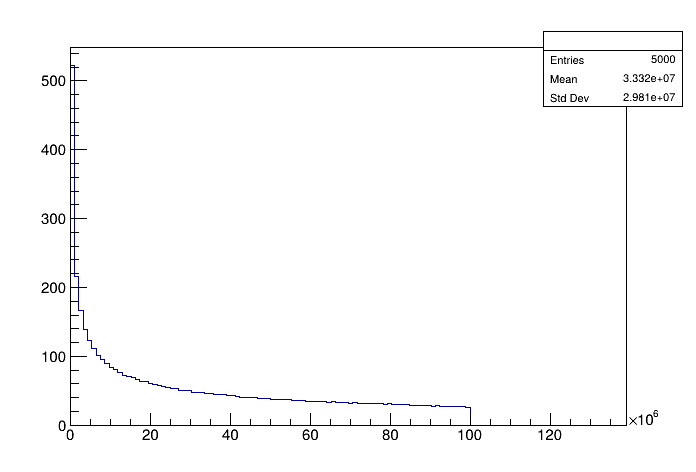

In [11]:
gROOT->GetListOfCanvases()->Draw()